In [1]:
# Installing the necessary packages
%pip install scikit-learn pandas numpy seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importing the packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# Train Data

In [3]:
# Viewing & Reading the Dataset
train = pd.read_csv("Data/train.csv")
train.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,2.5,2590.0,sqft,6000.00,sqft,98144,795000.0
1,4,2.0,2240.0,sqft,0.31,acre,98106,915000.0
2,4,3.0,2040.0,sqft,3783.00,sqft,98107,950000.0
3,4,3.0,3800.0,sqft,5175.00,sqft,98199,1950000.0
4,2,2.0,1042.0,sqft,NaN,NaN,98102,950000.0


In [4]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            2016 non-null   int64  
 1   baths           2016 non-null   float64
 2   size            2016 non-null   float64
 3   size_units      2016 non-null   object 
 4   lot_size        1669 non-null   float64
 5   lot_size_units  1669 non-null   object 
 6   zip_code        2016 non-null   int64  
 7   price           2016 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 126.1+ KB


,beds,baths,size,lot_size,zip_code,price
count,2016.000000,2016.000000,2016.000000,1669.000000,2016.000000,2.016000e+03
mean,2.857639,2.159970,1735.740575,3871.059694,98123.638889,9.636252e+05
std,1.255092,1.002023,920.132591,2719.402066,22.650819,9.440954e+05
min,1.000000,0.500000,250.000000,0.230000,98101.000000,1.590000e+05
25%,2.000000,1.500000,1068.750000,1252.000000,98108.000000,6.017500e+05
50%,3.000000,2.000000,1560.000000,4000.000000,98117.000000,8.000000e+05
75%,4.000000,2.500000,2222.500000,6000.000000,98126.000000,1.105250e+06
max,15.000000,9.000000,11010.000000,9998.000000,98199.000000,2.500000e+07


We can observe here that the data types are correct, so we won't need to change anything.

In [5]:
# Counting the missing values
print(train.isna().sum())

beds                0
baths               0
size                0
size_units          0
lot_size          347
lot_size_units    347
zip_code            0
price               0
dtype: int64


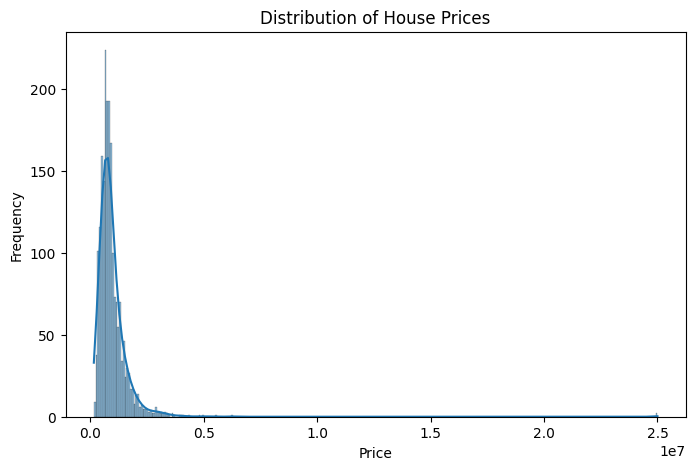

In [6]:
# Some Data Visualization
## Price (target variable) distribution
plt.figure(figsize=(8,5))
sns.histplot(train["price"], kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

We see that the House Prices distribution is heavily right-skewed, so to stabilize it more we will use the log

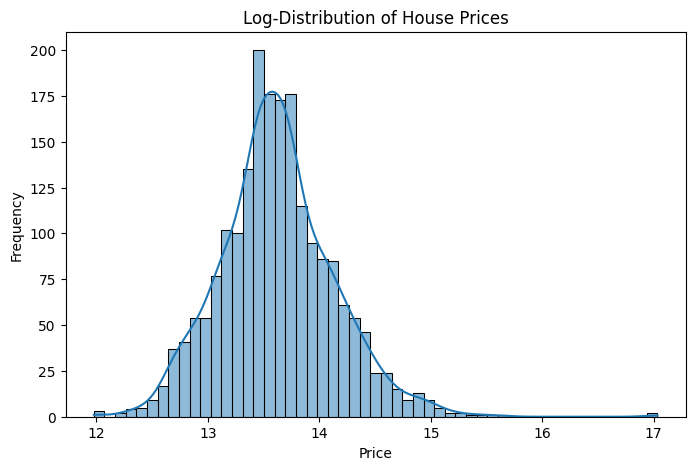

In [7]:
# Some Data Visualization
## Price (target variable) distribution
plt.figure(figsize=(8,5))
sns.histplot(np.log1p(train['price']), kde=True)
plt.title("Log-Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

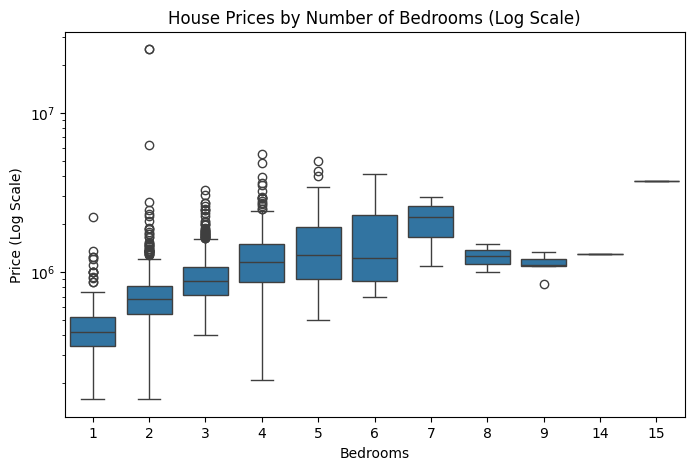

In [8]:
## Boxplot to see the outliers
plt.figure(figsize=(8,5))
sns.boxplot(x='beds', y='price', data=train)
plt.yscale('log')
plt.title('House Prices by Number of Bedrooms (Log Scale)')
plt.xlabel('Bedrooms')
plt.ylabel('Price (Log Scale)')
plt.show()

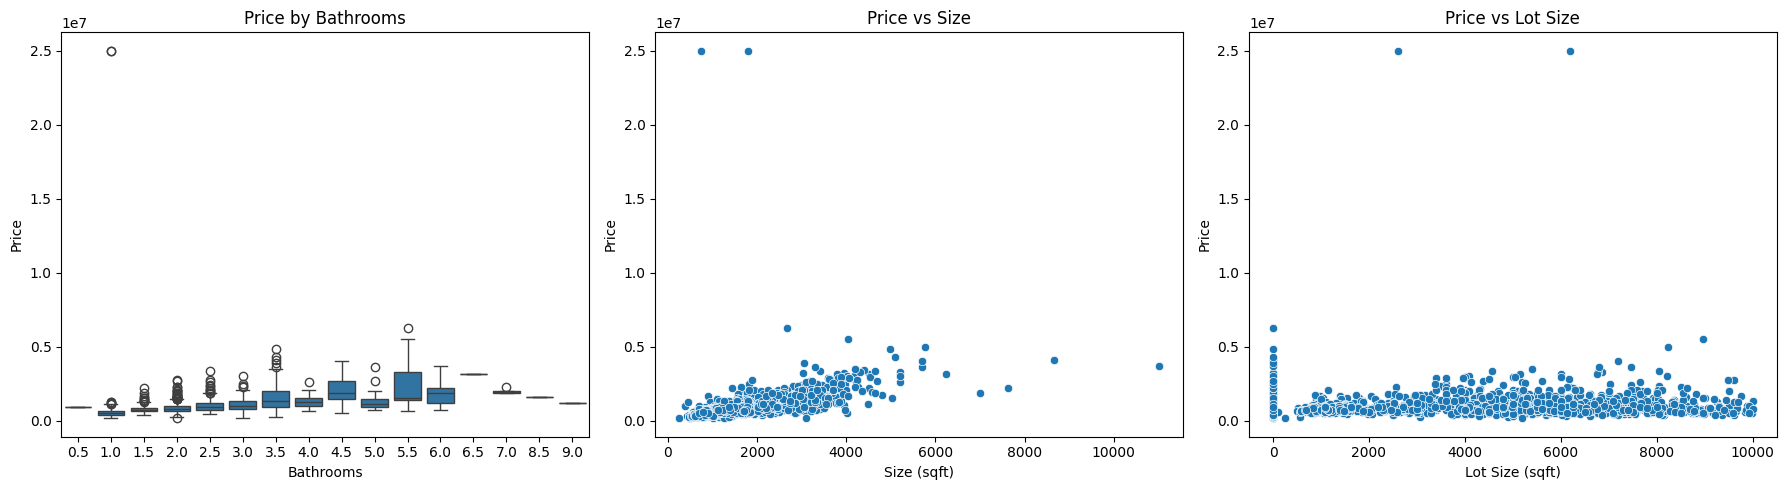

In [9]:
plt.figure(figsize=(18, 5))

### 1. Boxplot - Price vs Bathrooms
plt.subplot(1, 3, 1)
sns.boxplot(x='baths', y='price', data=train)
plt.title('Price by Bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Price')

### 2. Scatterplot - Price vs Size
plt.subplot(1, 3, 2)
sns.scatterplot(x='size', y='price', data=train)
plt.title('Price vs Size')
plt.xlabel('Size (sqft)')
plt.ylabel('Price')

### 3. Scatterplot - Price vs Lot Size
plt.subplot(1, 3, 3)
sns.scatterplot(x='lot_size', y='price', data=train)
plt.title('Price vs Lot Size')
plt.xlabel('Lot Size (sqft)')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

From what we viewed before, we see in `lot_size_units`, two units have been used. So we will need to unify them.

In [10]:
print(train['lot_size_units'].unique())

print(train['lot_size_units'].value_counts())

['sqft' 'acre' nan]
lot_size_units
sqft    1449
acre     220
Name: count, dtype: int64


Since 'sqft' is the most used, then we will map 'acre' to 'sqft'

In [11]:
# Conversion factor: 1 acre = 43560 sqft
to_be_changed = train["lot_size_units"] == "acre"
train.loc[to_be_changed, "lot_size"] *= 43560

print(train['lot_size_units'].unique())


['sqft' 'acre' nan]


Since the columns `size_units`, `lot_size_units` and `zip_code` are useless, we will remove them

In [12]:
train.drop(columns=['lot_size_units', 'size_units', 'zip_code'], inplace=True)
train.columns

Index(['beds', 'baths', 'size', 'lot_size', 'price'], dtype='object')

In [13]:
missing_counts = train.isnull().sum()
missing_percentage = (train.isnull().sum() / len(train)) * 100
print(missing_percentage)

beds         0.000000
baths        0.000000
size         0.000000
lot_size    17.212302
price        0.000000
dtype: float64


Since our distribution is skewed, we will replace the `lot_size` missing values by the median

In [14]:
median = train["lot_size"].median()
train["lot_size"] = train["lot_size"].fillna(median)
# We check again the null values
train.isna().sum()

beds        0
baths       0
size        0
lot_size    0
price       0
dtype: int64

In [15]:
# Checking duplicates
train.duplicated().sum()

np.int64(9)

In [16]:
# Dropping them
train.drop_duplicates(inplace=True)
train.duplicated().sum()

np.int64(0)

In [17]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 2007 entries, 0 to 2015
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   beds      2007 non-null   int64  
 1   baths     2007 non-null   float64
 2   size      2007 non-null   float64
 3   lot_size  2007 non-null   float64
 4   price     2007 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 94.1 KB


,beds,baths,size,lot_size,price
count,2007.000000,2007.000000,2007.000000,2.007000e+03,2.007000e+03
mean,2.861983,2.161435,1738.770802,1.647136e+04,9.640700e+05
std,1.255252,1.003035,920.334647,2.627309e+05,9.461237e+05
min,1.000000,0.500000,250.000000,5.000000e+02,1.590000e+05
25%,2.000000,1.500000,1070.000000,3.495500e+03,6.000000e+05
50%,3.000000,2.000000,1560.000000,5.000000e+03,8.000000e+05
75%,4.000000,2.500000,2230.000000,6.602000e+03,1.109000e+06
max,15.000000,9.000000,11010.000000,1.089000e+07,2.500000e+07


<Axes: >

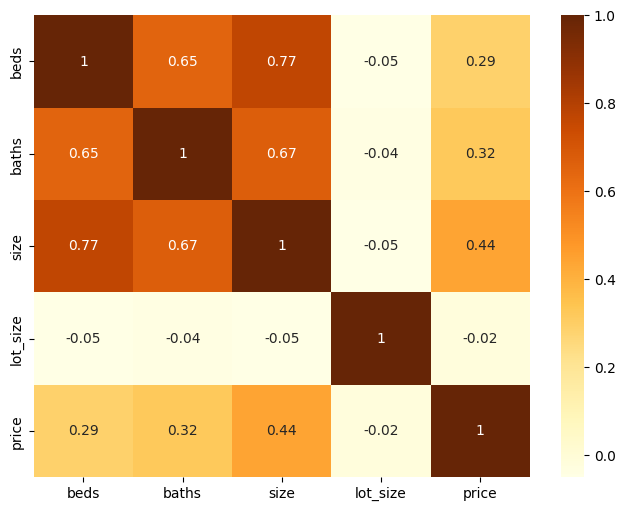

In [18]:
correl = train.corr().round(2)
plt.figure(figsize = (8,6))
sns.heatmap(correl, annot = True, cmap = 'YlOrBr')

We see that the size is the strongest predictor of price among the features.

# Test Data

We will do basically the same thing for the test dataset

In [19]:
test = pd.read_csv("Data/test.csv")
test.head()

,beds,baths,size,size_units,lot_size,lot_size_units,zip_code,price
0,3,3.0,2850.0,sqft,4200.00,sqft,98119,1175000.0
1,4,5.0,3040.0,sqft,5002.00,sqft,98106,1057500.0
2,3,1.0,1290.0,sqft,6048.00,sqft,98125,799000.0
3,3,2.0,2360.0,sqft,0.28,acre,98188,565000.0
4,3,3.5,1942.0,sqft,1603.00,sqft,98107,1187000.0


In [20]:
def clean_dataset(df):
    print(df.info())
    print(df.describe())
    print(df.isna().sum())
    print(df['lot_size_units'].unique())

    print(df['lot_size_units'].value_counts())

    # Convert 'acre' to sqft
    to_be_changed = df["lot_size_units"] == "acre"
    df.loc[to_be_changed, "lot_size"] *= 43560

    print(df['lot_size_units'].unique())

    # Drop unnecessary columns
    df.drop(columns=['lot_size_units', 'size_units', 'zip_code'], inplace=True)

    # Fill missing lot_size with median of this dataset
    median = df["lot_size"].median()
    df["lot_size"] = df["lot_size"].fillna(median)

    print(df.isna().sum())

    # Remove duplicates
    print("Duplicates before drop:", df.duplicated().sum())
    df.drop_duplicates(inplace=True)
    print("Duplicates after drop:", df.duplicated().sum())

    return df

test = clean_dataset(test)
test.info()
test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   beds            505 non-null    int64  
 1   baths           505 non-null    float64
 2   size            505 non-null    float64
 3   size_units      505 non-null    object 
 4   lot_size        428 non-null    float64
 5   lot_size_units  428 non-null    object 
 6   zip_code        505 non-null    int64  
 7   price           505 non-null    float64
dtypes: float64(4), int64(2), object(2)
memory usage: 31.7+ KB
None
             beds       baths         size     lot_size      zip_code  \
count  505.000000  505.000000   505.000000   428.000000    505.000000   
mean     2.954455    2.219802  1851.843564  3994.459813  98125.366337   
std      1.214947    1.013404   922.556090  2696.962024     24.875054   
min      1.000000    1.000000   376.000000     0.230000  98101.000000   
25%      2.00

,beds,baths,size,lot_size,price
count,504.000000,504.000000,504.000000,504.000000,5.040000e+02
mean,2.958333,2.222222,1854.771825,8355.428968,9.795417e+05
std,1.213022,1.012949,921.120496,17514.025903,6.090798e+05
min,1.000000,1.000000,376.000000,529.000000,1.700000e+05
25%,2.000000,1.500000,1173.250000,3770.750000,6.197425e+05
50%,3.000000,2.000000,1690.000000,5011.000000,8.400000e+05
75%,4.000000,2.500000,2402.500000,6780.000000,1.156250e+06
max,9.000000,7.000000,6139.000000,176853.600000,6.250000e+06


# Model Development

## 1- Linear Regression

In [21]:
# Splitting data into x and y frames:

# Explanatory variables
X = train.drop(columns=['price'])

# Target (response variable)
y = train['price']

X_test = test.drop(columns=['price'])
y_test = test['price']

We will perform Cross-Validation to:

    - Tune hyperparameters

    - Check model stability

    - Avoid overfitting

In [22]:
model = LinearRegression()
cv_results = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Calculate RMSE
rmse = (-cv_results.mean()) ** 0.5
print(f"Cross-Validation RMSE: {rmse:.2f}")

Cross-Validation RMSE: 845971.08


In [23]:
rmse_percent = (rmse / y.mean()) * 100
print(f"RMSE represents {rmse_percent:.2f}% of average price")

RMSE represents 87.75% of average price


This means that the model will poorly perform, that's why we will also use Ridge and Lasso Regression, and try to improve it

In [24]:
# Model train & prediction
model.fit(X, y)
y_pred = model.predict(X_test)

In [25]:
# Model Evaluation
test_rmse = root_mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R² Score: {test_r2:.3f}")

Test RMSE: 415568.27
Test R² Score: 0.534


This is somehow a decent result but we can still improve it

**Ridge Regression**

In [26]:
# List to store results
scores = []
alphas = [0.01, 0.1, 1, 10, 100, 500, 1000]

# Loop through each alpha and compute CV score
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    cv_rmse = cross_val_score(ridge, X, y, scoring='neg_mean_squared_error',cv=5)
    mean_rmse = (-cv_rmse.mean()) ** 0.5
    scores.append(mean_rmse)
    print(f"Alpha={alpha} | CV RMSE={mean_rmse:.2f}")

# Find best alpha
best_idx = np.argmin(scores)
best_alpha = alphas[best_idx]
best_rmse = scores[best_idx]

print(f"\n Best Alpha: {best_alpha} with CV RMSE: {best_rmse:.2f}")


Alpha=0.01 | CV RMSE=845971.05
Alpha=0.1 | CV RMSE=845970.80
Alpha=1 | CV RMSE=845968.33
Alpha=10 | CV RMSE=845944.72
Alpha=100 | CV RMSE=845799.33
Alpha=500 | CV RMSE=845942.80
Alpha=1000 | CV RMSE=846390.90

 Best Alpha: 100 with CV RMSE: 845799.33


In [27]:
ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X, y)
y_ridge_pred = ridge_model.predict(X_test)

In [28]:
# Model Evaluation
test_rmse_ridge = root_mean_squared_error(y_test, y_ridge_pred)
test_r2_ridge = r2_score(y_test, y_ridge_pred)

print(f"Test RMSE: {test_rmse_ridge:.2f}")
print(f"Test R² Score: {test_r2_ridge:.3f}")

Test RMSE: 415946.72
Test R² Score: 0.533


**Lasso Regression**

In [30]:
# List to store results
scores = []
alphas = [0.01, 0.1, 1, 10, 100, 500, 1000]

# Loop through each alpha and compute CV RMSE
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    cv_rmse = cross_val_score(lasso, X, y, scoring='neg_mean_squared_error', cv=5)
    mean_rmse = (-cv_rmse.mean()) ** 0.5
    scores.append(mean_rmse)
    print(f"Alpha={alpha} | CV RMSE={mean_rmse:.2f}")

# Best alpha selection
best_idx = scores.index(min(scores))
best_alpha = alphas[best_idx]
best_rmse = scores[best_idx]

print(f"\nBest Alpha: {best_alpha} with CV RMSE: {best_rmse:.2f}")

Alpha=0.01 | CV RMSE=845971.08
Alpha=0.1 | CV RMSE=845971.08
Alpha=1 | CV RMSE=845971.07
Alpha=10 | CV RMSE=845971.06
Alpha=100 | CV RMSE=845970.91
Alpha=500 | CV RMSE=845970.78
Alpha=1000 | CV RMSE=845972.07

Best Alpha: 500 with CV RMSE: 845970.78


In [31]:
# Final Lasso Model
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X, y)
y_lasso_pred = lasso_model.predict(X_test)

In [32]:
# Test Evaluation
test_rmse_lasso = root_mean_squared_error(y_test, y_lasso_pred)
test_r2_lasso = r2_score(y_test, y_lasso_pred)

print(f"Test RMSE: {test_rmse_lasso:.2f}")
print(f"Test R² Score: {test_r2_lasso:.3f}")

Test RMSE: 415623.06
Test R² Score: 0.533


## 📊 Overall Summary and Analysis

In this project, we worked exclusively with **numerical, continuous data**, focusing on basic house features such as **beds, baths, size, lot size**, and the **price** as the target variable. Our dataset was reasonably sized but limited in scope, which naturally affected the strength of the predictions.

---

### 🟠 Data Preparation Insights
During data exploration, we noticed:
- Some **null values**, particularly in `lot_size`, which we filled using the **median** to avoid skewing the data.
- Certain inconsistencies in measurement units (`lot_size_units`), which we **standardized to square feet** to ensure consistency.
- The removal of **irrelevant features** like `size_units` and `zip_code` was necessary since they were either redundant or irrelevant to the modeling process.

Despite preprocessing, the relationships between features and **price** remained relatively **weak or noisy** in exploratory plots, with **size** being the only variable showing a consistent increasing trend with price, which is logical for housing data.

---

### 🟢 Modeling Results
We evaluated three regression models:
- **Linear Regression** provided the **best overall performance**, reaching a **Test R² Score of ~53%** and a **Test RMSE around 415K**. This suggests a moderate ability to explain price variance while keeping the model simple and interpretable.
- **Ridge Regression** and **Lasso Regression** both produced **slightly worse results**, with marginally higher RMSE and lower R². This implies that adding regularization introduced **bias** without offering enough variance reduction, likely due to the **small number of features** and relatively **simple relationships** in the data.

---

### ✅ Conclusions
- The linear regression model was the **most suitable** in this scenario, **outperforming Ridge and Lasso**.
- The **modest R² score** suggests that a significant portion of **price variability remains unexplained**, possibly due to:
   - **Missing influential features** (e.g., location specifics, property condition),
   - **High variance** within the dataset itself,
   - Or the **limitations of linear models** in capturing more complex, non-linear relationships.
- Future improvements could include:
   - Testing **non-linear models** like Random Forest or Gradient Boosting,
   - **Feature engineering** to create more informative predictors,
   - Exploring **log-transformations** on price to reduce skewness and mitigate outlier impact.

---

In conclusion, with the available data and techniques used, the **simplest linear model** remained the most effective, setting a **baseline** for potential future improvements.
